In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from pysindy.utils.odes import lorenz
from pynew import *
import pysindy as ps

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

# integration keywords for solve_ivp, typically needed for chaotic systems
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

IndentationError: expected an indented block (weak_pde_library.py, line 770)

In [ ]:
dt = 0.001
t_train = np.arange(0, 10, dt)
t_train_span = (t_train[0], t_train[-1])
u0_train = [-8, 8, 27]
u_train = solve_ivp(lorenz, t_train_span, u0_train, 
                    t_eval=t_train, **integrator_keywords).y.T
import random as rand
error_scale = 0.1
noise = np.random.randn(10000, 3) * error_scale
u_train = u_train + noise

In [ ]:
np.shape(u_train)[0]

In [2]:
%%time
# Generate measurement data
dt = 0.001
t_train = np.arange(0, 10, dt)
t_train_span = (t_train[0], t_train[-1])
u0_train = [-8, 8, 27]
u_train = solve_ivp(lorenz, t_train_span, u0_train, 
                    t_eval=t_train, **integrator_keywords).y.T
import random as rand
error_scale = 0.1
noise = np.random.randn(10000, 3) * error_scale
u_train = u_train + noise

# Instantiate and fit the SINDy model with u_dot
u_dot = FiniteDifference()._differentiate(u_train, t=dt)
model = SINDy()
model.fit(u_train, x_dot=u_dot, t=dt)
model.print()

# Define weak form ODE library
# defaults to derivative_order = 0 if not specified,
# and if spatial_grid is not specified, defaults to None,
# which allows weak form ODEs.
library_functions = [lambda x: x, lambda x: x * x, lambda x, y: x * y]
library_function_names = [lambda x: x, lambda x: x + x, lambda x, y: x + y]
ode_lib = WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    spatiotemporal_grid=t_train,
    is_uniform=True,
    K=100,
)

# Instantiate and fit the SINDy model with the integral of u_dot
optimizer = SR3(
    threshold=0.05, 
    thresholder="l1", 
    max_iter=1000, 
    normalize_columns=True, 
    tol=1e-1
)
model = SINDy(feature_library=ode_lib, optimizer=optimizer)
model.fit(u_train)
model.print()

NameError: name 'integrator_keywords' is not defined

In [5]:
np.shape(u_train)

(10000, 3)

## Pysindy Version

In [6]:
%%time
# Generate measurement data
dt = 0.001
# integration keywords for solve_ivp, typically needed for chaotic systems
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12
t_train = np.arange(0, 10, dt)
t_train_span = (t_train[0], t_train[-1])
u0_train = [-8, 8, 27]
u_train = solve_ivp(lorenz, t_train_span, u0_train, 
                    t_eval=t_train, **integrator_keywords).y.T

# Instantiate and fit the SINDy model with u_dot
u_dot = ps.FiniteDifference()._differentiate(u_train, t=dt)
model = ps.SINDy()
model.fit(u_train, x_dot=u_dot, t=dt)
model.print()

# Define weak form ODE library
# defaults to derivative_order = 0 if not specified,
# and if spatial_grid is not specified, defaults to None,
# which allows weak form ODEs.
library_functions = [lambda x: x, lambda x: x * x, lambda x, y: x * y]
library_function_names = [lambda x: x, lambda x: x + x, lambda x, y: x + y]
ode_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    spatiotemporal_grid=t_train,
    is_uniform=True,
    K=100,
)

# Instantiate and fit the SINDy model with the integral of u_dot
optimizer = ps.SR3(
    threshold=0.05, 
    thresholder="l1", 
    max_iter=1000, 
    normalize_columns=True, 
    tol=1e-1
)
model = ps.SINDy(feature_library=ode_lib, optimizer=optimizer)
model.fit(u_train)
model.print()

(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 27.998 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1
(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 28.000 x0 + -1.000 x1 + -1.000 x0x2
(x2)' = -2.667 x2 + 1.000 x0x1
CPU times: user 649 ms, sys: 1.96 s, total: 2.61 s
Wall time: 286 ms


## Lorenz Attractor using foward euler

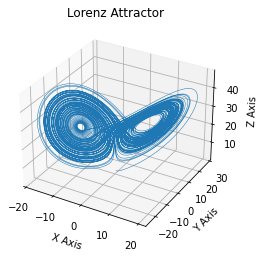

In [7]:
import numpy as np
import matplotlib.pyplot as plt


def lorenz(x, y, z, s=10, r=28, b=2.667):
    """
    Given:
       x, y, z: a point of interest in three dimensional space
       s, r, b: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z
    """
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return x_dot, y_dot, z_dot


dt = 0.001
num_steps = 100000

# Need one more for the initial values
xs = np.empty(num_steps + 1)
ys = np.empty(num_steps + 1)
zs = np.empty(num_steps + 1)

# Set initial values
xs[0], ys[0], zs[0] = (0., 1., 1.05)

# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i])
    xs[i + 1] = xs[i] + (x_dot * dt)
    ys[i + 1] = ys[i] + (y_dot * dt)
    zs[i + 1] = zs[i] + (z_dot * dt)


# Plot
ax = plt.figure().add_subplot(projection='3d')

ax.plot(xs, ys, zs, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

In [8]:
import pysindy as ps
# Define weak form ODE library
# defaults to derivative_order = 0 if not specified,
# and if spatial_grid is not specified, defaults to None,
# which allows weak form ODEs.
time_step = np.linspace(0, 100000*dt, 100001)
x_train = np.array([xs, ys, zs]).T
library_functions = [lambda x: x, lambda x: x * x, lambda x, y: x * y]
library_function_names = [lambda x: x, lambda x: x + x, lambda x, y: x + y]
ode_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    spatiotemporal_grid=time_step,
    is_uniform=True,
    K=100,
)

# Instantiate and fit the SINDy model with the integral of u_dot
optimizer = ps.SR3(
    threshold=0.05, 
    thresholder="l1", 
    max_iter=10000, 
    normalize_columns=False, 
    tol=1
)
model = ps.SINDy(feature_library=ode_lib, optimizer=optimizer)
model.fit(x_train)
model.print()

(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 27.808 x0 + -0.944 x1 + -0.995 x0x2
(x2)' = -2.667 x2 + 1.000 x0x1
